In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lung_fake/data.zip'

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

import glob,os

In [ ]:
data_aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    # rotation_range=15,
    # shear_range=0.2,
    # zoom_range=0.25,
   )

In [ ]:
data_aug_valid = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
train=data_aug_train.flow_from_directory(directory='/content/content/data/train/version_2/',
                                         target_size=(128,128),
                                         color_mode='rgb',
                                         classes=['real','fake'],
                                         shuffle=True,
                                         class_mode='binary', 
                                         batch_size=64)

In [ ]:
valid=data_aug_valid.flow_from_directory(directory='/content/content/Lung_fake/validation_data/data',
                                         target_size=(128,128),
                                         color_mode='rgb',
                                         classes=['real','fake'],
                                         shuffle=False,
                                         class_mode='binary', 
                                         batch_size=64)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
p_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
p_model.trainable=True

In [ ]:
p_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(p_model)
model.add(Flatten())
# finalize with standard Dense, Dropout...
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 15,239,117
Trainable params: 15,239,111
Non-trainable params: 6
____________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
filepath = '/content/drive/MyDrive/lung_fake/models_weight/27k_nocrop_VGG16{epoch:02d}val_acc{val_accuracy:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
history = model.fit( 
      train,
      validation_data = valid, 
      validation_steps = len(valid), 
      shuffle = True,    
      steps_per_epoch = len(train),     
      epochs = 50,
      callbacks=[checkpoint],  
      verbose = 1) 

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/fake_classification/models_weight/27k_nocrop_VGG1611val_acc0.809.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 15,239,117
Trainable params: 15,239,111
Non-trainable params: 6
____________________________________________

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Y_pred = model.predict_generator(valid)
Y_pred = model.predict_classes(valid)

In [ ]:
y_pred=[]
for x in Y_pred:
  # print(x[0])
  y_pred.append(x[0])

In [ ]:
y_true=valid.labels
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
y_pred=np.array(y_pred)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
accuracy= scores[1]*100
loss=scores[0]
print('Accuracy: ', accuracy)
print('Loss: ',  loss)

Accuracy:  85.60460805892944
Loss:  0.9938672184944153


In [ ]:
model.save("model.h5")

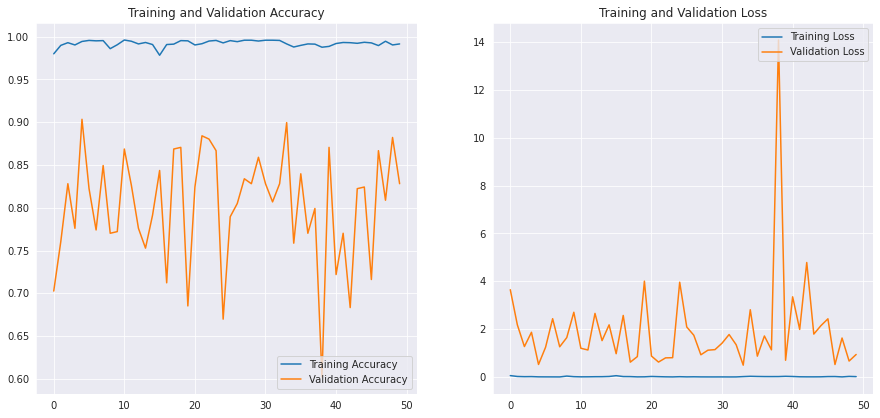

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()